In [217]:

import numpy as np
from math import gamma
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

import os
os.chdir("C:\\Users\\user\\Downloads\\Thesis_paper_1\\calibration")

np.set_printoptions(suppress=True) # supress scientific notation



In [106]:
## parameters



def get_data(year):
    w='data_' + str(year)
    alfa = np.array(pd.read_excel(f'{w}.xlsx').iloc[:,5])
    phi = np.array(pd.read_excel(f'{w}.xlsx').iloc[:,4])
    return alfa, phi



def pars(year):
    global alfa, rho, beta, theta, eta, psi, kappa, lamb, gamma1, G, phi
    rho = 0.19
    beta = 0.69
    theta = 3.44
    eta = 0.25
    psi = eta**eta*(1-eta)**(1-eta)
    kappa = 1/(1 - eta)

    lamb = (theta*(1 - eta) - 1 ) / (theta*(1- eta)) 
    gamma1 = eta*kappa
    
    G = gamma(1 - np.multiply( np.divide(1, np.multiply(theta, (1-rho)) ), np.divide(1, (1 - eta) ) ) )   
    
    alfa, phi = get_data(year)



In [145]:
# taus

st=8
def taus2(st):        
    tau = np.random.uniform(low=-0.989, high=5e4, size=(st)) 
    tau[7] = 0
    x1 = np.array(tau)    
    return x1

In [5]:
# Time spent at school

def sf( ):
    global s
    s = np.power( (1 + np.divide( (1-eta), ( np.multiply(beta, phi) ) ) ), -1 )
    #s = s.reshape(st, 1)
    return s





In [6]:

## N_i = H_i / w_i^gamma1


def N_if(x1):
    s = sf()
    T = np.multiply(np.power((1 + x1), (-1*theta*lamb-gamma1)), np.power(psi, theta*lamb) )    
    S = np.power(s, (phi*(theta*lamb + (1-gamma1)))  )
    S2 = np.multiply(np.power((1 - s), (((1 - eta)*theta*lamb)/beta)  ), np.power(eta, gamma1) )
    N_i = np.multiply(np.multiply(T, np.multiply(S, S2)), G)
    return N_i



In [7]:

#  linear system 


def lin_sys(x1):
#    global A, B, C, D, N_i
    A = np.repeat(alfa, st).reshape(st, st).T  # matriz de parâmetros    
    B = np.repeat(alfa, st).reshape(st, st).T        # Matriz de alfas 
    for i in range(st):
        for j in range(st):
            if i==j:
                A[i, j] = 1 - (A[i, j] - 1)*(theta*lamb + gamma1)
                B[i, j] = B[i, j] - 1
            if i != j:
                A[i, j] = -A[i, j]*(theta*lamb + gamma1) 
  
    N_i = np.log( N_if(x1) )          # Logaritmo de N_i
    C = np.log(alfa)                  # Logaritmo dos alfas
    D = np.dot(B, N_i) + C            # produto matricial      
    lin = np.linalg.solve(A, D)       # Resolvendo o sistema  A w = D
    res = np.exp(lin)
    return res


In [8]:
# w_til


def w_til_f(x1):
    s = sf()
    A = np.multiply(np.power((1 + x1), -eta), w )
    S = np.multiply(np.power(s, phi), np.power((1 - s), ((1-eta)/beta) ) )    
    w_til = np.multiply(psi, np.multiply(A, S) )    
    return w_til




In [9]:
# p_i

def p_i_f(x1):
    w_til = w_til_f(x1)
    p_i =  np.power(w_til, theta)/ np.sum( np.power(w_til, theta) )   
    return p_i



In [10]:
# wages - model 

def W_i_f(x1):
    w_til = w_til_f(x1)
    S_wtil = np.power((np.sum( np.power(w_til, theta) ) ), (kappa/theta) )
    S = np.power((1-s), (-1/beta))
    W_i = 1/kappa*np.multiply(np.multiply(S, S_wtil), G )     
    return W_i

    



In [11]:

# PNAD - DATA


def get_p_i(year):
    global p_s2
    w='data_' + str(year)
    p_i = np.array(pd.read_excel(f'{w}.xlsx').iloc[:,2])
    p_s2 = p_i[1:st]
    return p_i


def get_W_i(year):
    global p_s2
    w='data_' + str(year)
    W_i = np.array(pd.read_excel(f'{w}.xlsx').iloc[:,1])
    return W_i


In [146]:
# Objective function



def obj2(x1):    
    global w
    x1 = x1.reshape((st)) 
    x1[7] = 0 
    w = lin_sys(x1) 
    W_i = W_i_f(x1) 
    p_i = p_i_f(x1)   
    p_i = p_i[1:st]    
    D = np.sum(np.power( np.divide(( p_s2 - p_i ), p_s2 )  , 2 ) )
    D = np.log(D)
    return D


In [13]:
# bounds

Bd = ((-0.99, 5e4), )*st 
Bd = np.array(Bd, dtype=object)


In [14]:
# callback


cc = 0
def callback(x):
    global cc
    cc += 1
    fobj = obj2(x)
    print(f'\033[1;033mObjetivo: {np.around(fobj, 5)}, iter: {cc}') 


In [218]:
# solver 1
#pars(2)
#get_p_i(2)

#cc=0
#sol= minimize(obj2, taus2(8),  method='Nelder-Mead', 
#              callback=callback, 
#              tol=1e-9, options={'maxiter':2e4})


# Results

In [215]:
# occupations

ocp = np.array(['AGR', 'IND_EXTR', 'IND_TRANSF', 'IND_CONST',
                'SERV_COMER', 'SERV_TRANSP_ARM',  'SERV_FIN_IMOB', 'ADM_SAUDE_EDUC'])


names = np.array(pd.read_excel('IPEA_PIBS.xls', sheet_name='nomes', header=None)).reshape(1, 8)


for i in range(8):
    print(f'{names[:,i]} -------> {ocp[i]}')

['Agricultura'] -------> AGR
['Indústria extrativa'] -------> IND_EXTR
['Indústria de transformação'] -------> IND_TRANSF
['Indústria de construção'] -------> IND_CONST
['Serviços - comércio'] -------> SERV_COMER
['Serviços - transporte, armazenagem e correios'] -------> SERV_TRANSP_ARM
['Serviços financeiros e imobiliários'] -------> SERV_FIN_IMOB
['Administração, saúde e educação públicas'] -------> ADM_SAUDE_EDUC


In [166]:
# get distortions


def get_dist(year):
    global w
    pars(year)
    get_p_i(year)    
    l ='dist_' + str(year)
    dist = np.array(pd.read_excel('dist.xlsx').loc[:,l])
    w = lin_sys(dist)
    return dist
    

In [188]:
# Distortions of 2002 and 2015

pd.read_excel('dist.xlsx').iloc[:,1:3]

,dist_2,dist_15
0,6.898531,4.576162
1,-0.686666,-0.690397
2,3.757057,3.417377
3,4.799547,4.981992
4,5.955905,5.308756
5,4.797111,4.743143
6,-0.406434,-0.515171
7,0.000000,0.000000


## Fit Quality

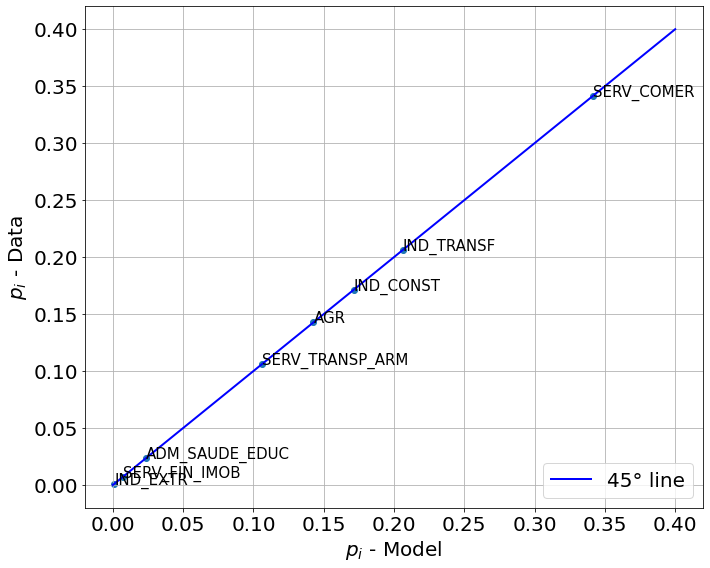

In [216]:
def g_pif(x):
    p_i = p_i_f(get_dist(x))
    p_s = get_p_i(x)       
    fig,ax = plt.subplots(figsize=(10,8))
    plt.scatter(p_i, p_s)
    for tt, txt in enumerate(ocp):
        plt.annotate(txt, (p_i[tt], p_s[tt]), size=15)  

    plt.plot([0.0, 0.4], [0.0, 0.4], 'k-', lw=2, label='45° line', color='blue')
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r"$p_i$ - Model", fontsize=20)
    plt.ylabel(r"$p_i$ - Data", fontsize=20)
    plt.legend(loc="lower right", prop={'size': 20})
    plt.tight_layout()  

g_pif(15)

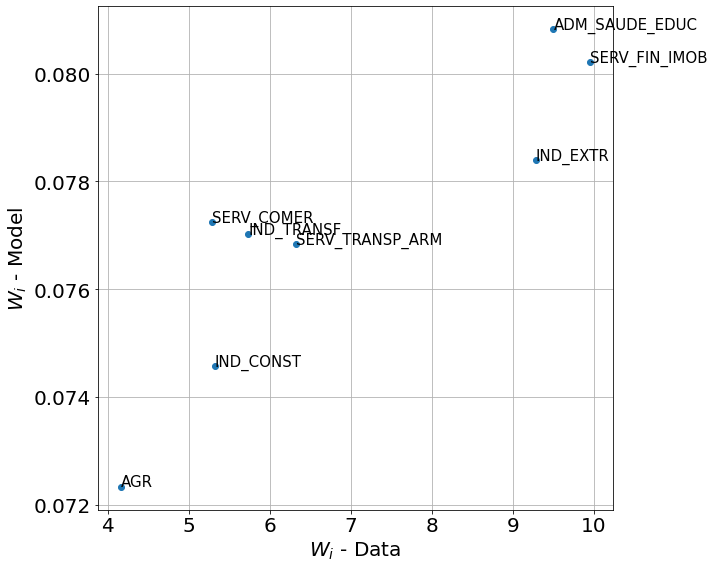

In [176]:
def Wi_plot(year):
    fig,ax = plt.subplots(figsize=(10,8))
    plt.scatter(get_W_i(year), W_i_f(get_dist(year)) )
    for tt, txt in enumerate(ocp):
        plt.annotate(txt, (get_W_i(year)[tt], W_i_f(get_dist(year))[tt] ), size=15)  
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r"$W_i$ - Data", fontsize=20)
    plt.ylabel(r"$W_i$ - Model", fontsize=20)
    plt.tight_layout()  
    
    
Wi_plot(15)

## Human capital

In [173]:

# human capital

def hc_plt(year):
    N_i = N_if(get_dist(year))
    H_i = np.multiply(N_i, np.power(w, gamma1) ) 
    fig,ax = plt.subplots(figsize=(10,8))
    plt.scatter(H_i, w, s=50)
    for tt, txt in enumerate(ocp):
        plt.annotate(txt, (H_i[tt], w[tt]), size=15)  
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r"$H_i$ - Model", fontsize=20)
    plt.ylabel(r"$w_i$ - Model", fontsize=20)
    plt.tight_layout() 



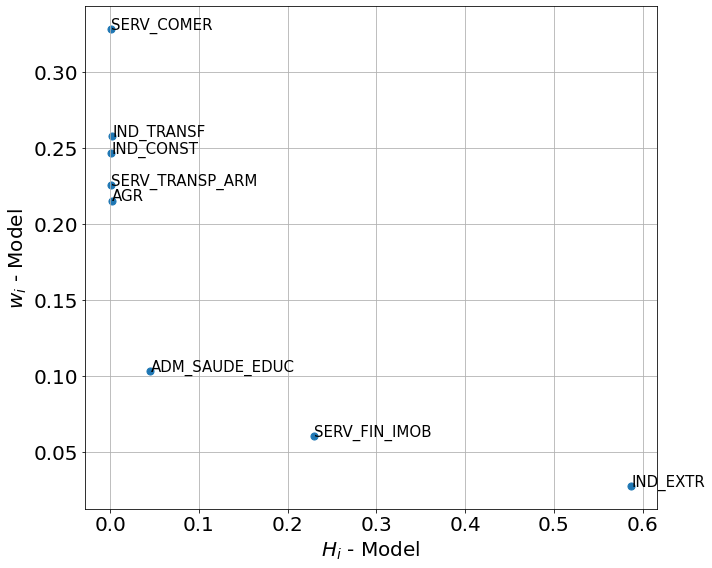

In [179]:
hc_plt(15)

## Proportion of people in each occupation

In [180]:
# p_i

def pi_plot(year):
    fig,ax = plt.subplots(figsize=(10,8))
    plt.scatter( p_i_f(get_dist(year)), w, s=20)
    for tt, txt in enumerate(ocp):
        plt.annotate(txt, (p_i_f(get_dist(year))[tt], w[tt]), size=15)  
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r"$p_i$ - Model", fontsize=20)
    plt.ylabel(r"$w_i$ - Model", fontsize=20)
    plt.tight_layout() 

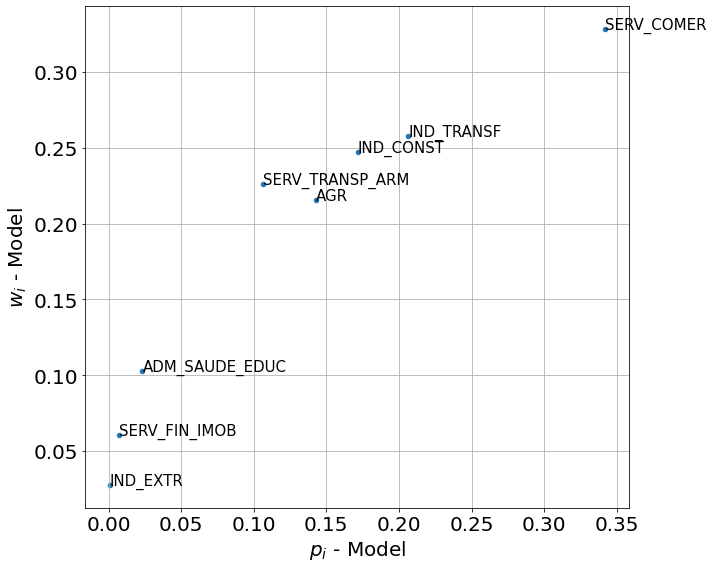

In [181]:
pi_plot(15)

## Increases in distortions and effects on GDP

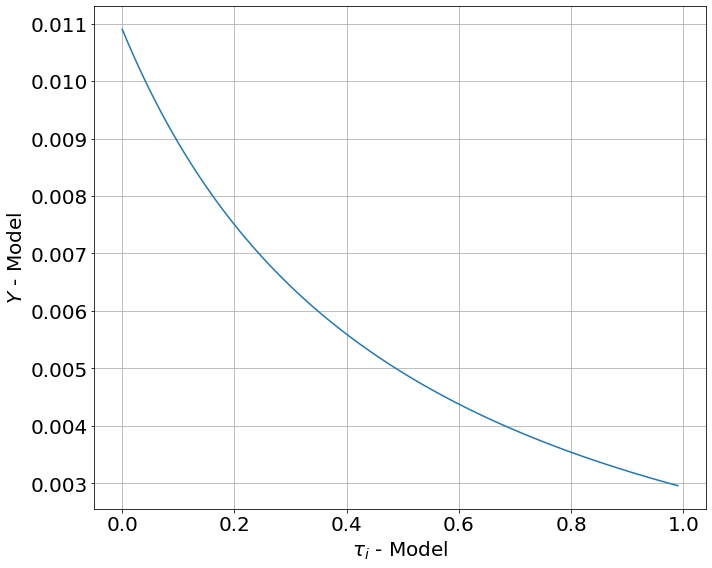

In [182]:
# output

t_y = np.arange(0, 1, 0.01)
Y_tau = []

for i  in t_y:
    res = get_dist(15) + i    
    N_i = N_if(res)
    H_i = np.multiply(N_i, np.power(w, gamma1) ) 
        
    Y_tau.append( np.prod(np.power(H_i, alfa )) )
    
plt.subplots(figsize=(10,8))
plt.plot(t_y, Y_tau)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r"$\tau_i$ - Model", fontsize=20)
plt.ylabel(r"$Y$ - Model", fontsize=20)
plt.tight_layout() 

## Alphas and w

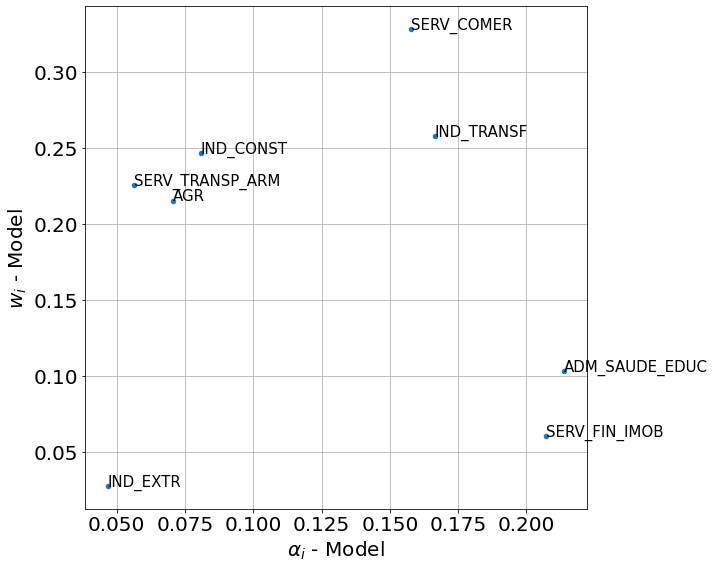

In [183]:
# alphas
get_dist(15)

fig,ax = plt.subplots(figsize=(10,8))
plt.scatter( alfa, w, s=20)
for tt, txt in enumerate(ocp):
    plt.annotate(txt, (alfa[tt], w[tt]), size=15)  
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r"$\alpha_i$ - Model", fontsize=20)
plt.ylabel(r"$w_i$ - Model", fontsize=20)
plt.tight_layout() 